In [62]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt

In [63]:
country_geo = 'datasets/all_countries.geo.json'

In [64]:
## Gather all sets
covid_data = pd.read_csv('datasets/COVID-19-worldwide.csv')
pop_dens = pd.read_csv('datasets/population_density.csv')
tourism_data = pd.read_csv('datasets/tourism_data.csv')
#sqmt = pd.read_csv('datasets/squaremeter_per_country.csv')
urban_area = pd.read_csv('datasets/urban_landarea.csv')
urban_pop = pd.read_csv('datasets/urban_pop.csv')
rural_pop = pd.read_csv('datasets/rural_pop.csv')
trust_in_pol = pd.read_csv('datasets/trust_in_politicians.csv')
gov_eff = pd.read_csv('datasets/gov_effectiveness.csv')

## Set correct indices
trust_in_pol.set_index('Country ISO3',inplace=True)
gov_eff.set_index('Country ISO3',inplace=True)
rural_pop.set_index('Country Code',inplace=True)
urban_pop.set_index('Country Code',inplace=True)
tourism_data.set_index('Country Code',inplace=True)
pop_dens.set_index('Country Code',inplace=True)
urban_area.set_index('Country Code',inplace=True)

In [65]:
# Clean datasets
trust_in_pol = trust_in_pol.loc[(trust_in_pol['Indicator'] == 'Public trust in politicians') & (trust_in_pol['Subindicator Type'] == '1-7 Best')]
trust_in_pol = trust_in_pol[['Country Name','2017-2018']]
trust_in_pol['2017-2018'] = trust_in_pol['2017-2018'].round(3);

gov_stats = gov_eff[['Country Name','Indicator','Subindicator Type','2018']]
gov_stats_corruption = gov_stats.loc[(gov_stats['Indicator'] == 'Control of Corruption') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_effectiveness = gov_stats.loc[(gov_stats['Indicator'] == 'Government Effectiveness') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_rule = gov_stats.loc[(gov_stats['Indicator'] == 'Rule of Law') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_reg = gov_stats.loc[(gov_stats['Indicator'] == 'Regulatory Quality') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_full = gov_stats_corruption.append([gov_stats_effectiveness,gov_stats_rule,gov_stats_reg])
gov_stats_full.sort_index()
gov_stats_full.dropna(inplace=True)

rural_2018 = rural_pop[['Country Name','2018']]
rural_2018 = rural_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

urban_2018 = urban_pop[['Country Name','2018']]
urban_2018 = urban_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

pop_dens = pop_dens[['Country Name','2018']]
tourism_data = tourism_data[['Country Name', '2018']]
t_data = tourism_data.drop(index=['WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU',
                            'UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA',
                            'ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA',
                            'SAS'])

In [325]:
t = covid_data.groupby('countryterritoryCode').count()
new_df = covid_data
new_df = new_df.set_index('countryterritoryCode')
new_df['total_deaths'] = 0
new_df['total_cases'] = 0
new_df['deaths_per_100k'] = 0
new_df['cases_per_100k'] = 0
new_df['current_infection_rate'] = 0
new_df['tourists_per_100k'] = 0
new_df['urban_pop_per_100k'] = 0
new_df['rural_percent'] = 0
new_df['trust_in_politicians'] = 0
new_df['rule_of_law'] = 0
new_df['gov_effectiveness'] = 0
new_df['reg_quality'] = 0
new_df['corruption_control'] = 0
new_df['average_infection_rate'] = 0

new_df = new_df[::-1]

for idx, row in t.iterrows():
    new_df.loc[[idx],['total_deaths']] = new_df.loc[idx]['deaths'].cumsum(axis=0)
    new_df.loc[[idx],['total_cases']] = new_df.loc[idx]['cases'].cumsum(axis=0)
    
    new_df.loc[[idx],['deaths_per_100k']] = (100000 * (new_df.loc[idx]['total_deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['cases_per_100k']] = (100000 * (new_df.loc[idx]['total_cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    if(idx in urban_2018.index):
        new_df.loc[[idx],['urban_pop_per_100k']] = (100000 * (urban_2018.loc[idx]['2018'] / new_df.loc[idx]['popData2018'])).round(3)
        
    if(idx in rural_2018.index):
        new_df.loc[[idx],['rural_percent']] = rural_2018.loc[idx]['2018']

    if(idx in trust_in_pol.index):
        new_df.loc[[idx],['trust_in_politicians']] = trust_in_pol.loc[idx]['2017-2018']
        
    if(idx in gov_stats_full.index):
        new_df.loc[[idx],['rule_of_law']] = gov_stats_rule.loc[idx]['2018']
        new_df.loc[[idx],['gov_effectiveness']] = gov_stats_effectiveness.loc[idx]['2018']
        new_df.loc[[idx],['reg_quality']] = gov_stats_corruption.loc[idx]['2018']
        new_df.loc[[idx],['corruption_control']] = gov_stats_reg.loc[idx]['2018']
    
    if(idx in tourism_data.index):
        tourists_total = tourism_data.loc[idx]['2018']
        new_df.loc[[idx],['tourists_per_100k']] = 100000*(tourists_total / new_df.loc[idx]['popData2018']).round(3)
        
for i in range(2,len(new_df)):
    current_country = new_df.iloc[i].name
    previous_country = new_df.iloc[i-1].name
    if(current_country == previous_country):
        previous_cases = new_df.iloc[i-1,new_df.columns.get_loc('cases')]
        current_cases = new_df.iloc[i,new_df.columns.get_loc('cases')]
        # Avoiding zero-division
        if(previous_cases > 0 and current_cases > 0):
            new_df.iloc[i,new_df.columns.get_loc('current_infection_rate')] = (current_cases / previous_cases).round(1)

for idx, row in t.iterrows():
    new_df.loc[[idx],['average_infection_rate']] = (1000 * new_df.loc[idx]['current_infection_rate'].mean())
            
new_df = new_df[::-1]

In [326]:
full_set = new_df.drop(columns=['day','month','year','cases','deaths'])

In [323]:
full_set.loc['SWE']

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate
countryterritoryCode,,,,,,,,,,,,,,,,,,,
SWE,4/27/2020,Sweden,SE,10183175.0,Europe,2194,18640,21.545,183.047,0.8,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/26/2020,Sweden,SE,10183175.0,Europe,2192,18177,21.526,178.500,0.8,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/25/2020,Sweden,SE,10183175.0,Europe,2152,17567,21.133,172.510,1.1,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/24/2020,Sweden,SE,10183175.0,Europe,2021,16755,19.846,164.536,1.1,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/23/2020,Sweden,SE,10183175.0,Europe,1937,16004,19.022,157.161,1.3,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/22/2020,Sweden,SE,10183175.0,Europe,1765,15322,17.333,150.464,1.4,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/21/2020,Sweden,SE,10183175.0,Europe,1580,14777,15.516,145.112,0.7,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/20/2020,Sweden,SE,10183175.0,Europe,1540,14385,15.123,141.262,0.9,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992
SWE,4/19/2020,Sweden,SE,10183175.0,Europe,1511,13822,14.838,135.734,0.9,73100.0,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,0.678992


In [ ]:
#new_df[new_df['dateRep'] == '4/27/2020'].sort_values('urban_pop_per_100k',ascending=False)[:20]

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=present_day_df,
    columns=[present_day_df.index,'deaths_per_100k'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='pop',
    bins=bins,
    reset=True
).add_to(m)

In [ ]:
m

In [290]:
full_set.corr()

,popData2018,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,built_per_sqkm,built_percent_of_land_area,tourists_per_built
popData2018,1.000000,0.104782,0.170267,-0.030447,-0.061788,0.019784,-0.114633,-0.097030,0.133853,0.147535,-0.065434,0.001975,-0.087481,-0.079390,0.629883,-0.072780,-0.030904
total_deaths,0.104782,1.000000,0.891762,0.366677,0.223253,0.015808,-0.026223,0.071414,-0.060151,0.063405,0.091233,0.100250,0.081478,0.096012,0.299369,0.004368,-0.014632
total_cases,0.170267,0.891762,1.000000,0.230798,0.181921,0.017661,-0.035940,0.070583,-0.058089,0.093907,0.092960,0.109803,0.083429,0.098508,0.424799,-0.005729,-0.015611
deaths_per_100k,-0.030447,0.366677,0.230798,1.000000,0.754194,0.024582,0.190983,0.130803,-0.144754,-0.073013,0.091124,0.088869,0.087026,0.081062,0.007625,0.093070,0.016310
cases_per_100k,-0.061788,0.223253,0.181921,0.754194,1.000000,0.026658,0.328044,0.074272,-0.191261,-0.100139,0.159803,0.154340,0.154869,0.137739,-0.023399,0.304533,0.036031
current_infection_rate,0.019784,0.015808,0.017661,0.024582,0.026658,1.000000,0.005395,0.024466,-0.006480,0.025047,-0.005297,0.001740,-0.009054,0.002825,0.015510,-0.002308,-0.019948
tourists_per_100k,-0.114633,-0.026223,-0.035940,0.190983,0.328044,0.005395,1.000000,0.251166,-0.197618,-0.151130,0.222266,0.210469,0.188594,0.169157,-0.111905,0.203469,0.134768
urban_pop_per_100k,-0.097030,0.071414,0.070583,0.130803,0.074272,0.024466,0.251166,1.000000,-0.734470,0.357996,0.418758,0.445110,0.417546,0.416923,0.092968,0.204830,0.024030
rural_percent,0.133853,-0.060151,-0.058089,-0.144754,-0.191261,-0.006480,-0.197618,-0.734470,1.000000,-0.179425,-0.473526,-0.504538,-0.471526,-0.474961,-0.055911,-0.302486,-0.013178
trust_in_politicians,0.147535,0.063405,0.093907,-0.073013,-0.100139,0.025047,-0.151130,0.357996,-0.179425,1.000000,0.556481,0.589699,0.557741,0.546372,0.217087,0.061099,-0.167939


In [232]:
GHS_stats = pd.read_excel('datasets/xghs_stats.xls')

In [198]:
GHS_stats.head()

,ID_HDC_G0,QA2_1V,AREA,BBX_LATMN,BBX_LONMN,BBX_LATMX,BBX_LONMX,GCPNT_LAT,GCPNT_LON,CTR_MN_NM,...,EX_SS_P90,EX_SS_P00,EX_SS_P15,EX_EQ19PGA,EX_EQ19MMI,EX_EQ19_Q,EX_HW_IDX,SDG_LUE9015,SDG_A2G14,SDG_OS15MX
0,1.0,1.0,185.0,21.247683,-158.043016,21.422193,-157.730529,21.340678,-157.893497,United States,...,327680.831522,397443.031445,444041.529529,NAN,NAN,missing,NAN,0.0743852,0.226415,56.41
1,2.0,2.0,42.0,-17.641184,-149.628088,-17.517631,-149.508018,-17.534103,-149.568053,French Polynesia,...,0.000000,0.000000,0.000000,NAN,NAN,missing,NAN,0.127997,0.284119,NAN
2,3.0,1.0,55.0,34.858517,-120.475511,34.989334,-120.389183,34.923123,-120.434372,United States,...,0.000000,0.000000,0.000000,0,0,available,2.79174,0.481144,0.040129,23.64
3,4.0,1.0,48.0,36.582997,-121.952215,36.635743,-121.811816,36.607720,-121.882378,United States,...,0.000000,0.000000,0.000000,0,0,available,NAN,0.44484,0.138683,42.17
4,5.0,1.0,60.0,34.388220,-119.853855,34.457831,-119.658413,34.427664,-119.743693,United States,...,0.000000,0.000000,0.000000,0,0,available,4.25502,0.556762,0.061348,36.5


In [233]:
GHS_stats.set_index('XC_ISO_LST',inplace=True)

In [234]:
GHS_stats = GHS_stats[['H00_AREA','B15','P15','BUCAP15']]

In [235]:
GHS_stats.dropna(axis=0,inplace=True)

In [236]:
GHS_stats.sort_index(inplace=True)

In [237]:
for idx in GHS_stats.index.unique():
    if(len(str(idx)) > 3):
       GHS_stats.drop(idx,inplace=True)

In [238]:
GHS_stats['P15_total'] = 0
GHS_stats['B15_total'] = 0
GHS_stats['H00_Area_total'] = 0
GHS_stats['BUCAP15_total'] = 0
for idx in GHS_stats.index.unique():
    GHS_stats.loc[[idx],['P15_total']] = GHS_stats.loc[idx]['P15'].sum(axis=0)
    GHS_stats.loc[[idx],['B15_total']] = GHS_stats.loc[idx]['B15'].sum(axis=0)
    GHS_stats.loc[[idx],['H00_Area_total']] = GHS_stats.loc[idx]['H00_AREA'].sum(axis=0)
    GHS_stats.loc[[idx],['BUCAP15_total']] = GHS_stats.loc[idx]['BUCAP15'].sum(axis=0)


In [217]:
GHS_stats.head()

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
AFG,0.0,0.027299,58286.148438,0.468362,1.305593e+07,244.339929,654.0,732.867898
AFG,0.0,0.003104,77331.023438,0.040139,1.305593e+07,244.339929,654.0,732.867898
AFG,24.0,11.794139,190792.738647,61.816498,1.305593e+07,244.339929,654.0,732.867898
AFG,3.0,0.021398,51700.967773,0.413880,1.305593e+07,244.339929,654.0,732.867898
AFG,0.0,0.093960,67835.461914,1.385116,1.305593e+07,244.339929,654.0,732.867898


In [220]:
GHS_stats.sort_values('P15_total',ascending=True)[:20]

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
BRN,0.0,4.296262,51822.582123,82.903275,51822.582123,4.296262,0.0,82.903275
JEY,0.0,10.266114,53903.887314,190.452206,53903.887314,10.266114,0.0,190.452206
STP,0.0,0.000000,63612.541962,0.000000,63612.541962,0.000000,0.0,0.000000
NCL,25.0,12.111768,70631.796295,171.477555,70631.796295,12.111768,25.0,171.477555
BLZ,0.0,6.470197,72100.680557,89.738365,72100.680557,6.470197,0.0,89.738365
SLB,0.0,4.069641,73669.684235,55.241734,73669.684235,4.069641,0.0,55.241734
PYF,29.0,14.493433,91521.124603,158.361614,91521.124603,14.493433,29.0,158.361614
MNE,27.0,15.164762,96057.542114,157.871648,96057.542114,15.164762,27.0,157.871648
BTN,0.0,0.001428,105227.953125,0.013571,105227.953125,0.001428,0.0,0.013571


In [226]:
GHS_stats.groupby(GHS_stats.index)

In [239]:
newghs = GHS_stats.groupby('XC_ISO_LST').first()

In [240]:
newghs.sort_values('B15_total',ascending=False)[:20]

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
USA,0.0,29.058603,71884.521484,404.240060,1.445553e+08,60029.776487,72884.0,156851.658713
CHN,13.0,3.871886,118093.633484,32.786575,5.655431e+08,49218.630010,83795.0,174748.014863
IND,25.0,5.624630,556749.586933,10.102621,6.998501e+08,16100.277576,52795.0,50991.596852
JPN,0.0,12.706248,52828.846921,240.517237,8.449576e+07,14515.452114,21741.0,31183.695081
BRA,17.0,8.500335,83453.362900,101.857306,1.113409e+08,10279.459906,17576.0,36555.930948
RUS,131.0,74.068237,456156.558197,162.374597,6.376249e+07,9011.866801,14839.0,36829.833932
IDN,20.0,3.423428,66614.297546,51.391795,1.466925e+08,8131.489736,23386.0,18212.187049
GBR,38.0,28.527525,78309.925499,364.290028,3.778178e+07,6662.397537,10297.0,26968.721635
MEX,37.0,26.650537,166325.007130,160.231693,6.694493e+07,6310.085196,9007.0,17019.166702


In [327]:
built_up = pd.read_csv('datasets/built_up.csv')

In [245]:
built_up.head()

,COU,Country,MEAS,Measure,MAREG,Macroregion,MIREG,Microregion,VAR,Variable,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,1990,KM2,Square kilometres,0,Units,NaN,NaN,9287.01426,NaN,NaN
1,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2000,KM2,Square kilometres,0,Units,NaN,NaN,10382.86032,NaN,NaN
2,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2014,KM2,Square kilometres,0,Units,NaN,NaN,11681.98863,NaN,NaN
3,AUS,Australia,PCNT,Percent of total land area,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,1990,PC,Percentage,0,Units,NaN,NaN,0.12103,NaN,NaN
4,AUS,Australia,PCNT,Percent of total land area,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2000,PC,Percentage,0,Units,NaN,NaN,0.13531,NaN,NaN


In [328]:
built_up = built_up[['COU','Country','Measure','Variable','Year','Unit Code','Unit','Value']]

In [329]:
built_up.set_index('COU',inplace=True)

In [330]:
built_up = built_up[built_up['Year'] == 2014]

In [253]:
built_up.loc['USA']

,Country,Measure,Variable,Year,Unit Code,Unit,Value
COU,,,,,,,
USA,United States,Square kilometers,Area built-up before,2014,KM2,Square kilometres,150439.03051
USA,United States,Percent of total land area,Area built-up before,2014,PC,Percentage,1.63208


In [281]:
built_up.loc['FRO']

Country            Faeroe Islands
Measure         Square kilometers
Variable     Area built-up before
Year                         2014
Unit Code                     KM2
Unit            Square kilometres
Value                           0
Name: FRO, dtype: object

In [331]:
built_up.drop('FRO',inplace=True)

In [332]:
full_set['built_per_sqkm'] = 0
full_set['built_percent_of_land_area'] = 0 

for idx, row in t.iterrows():
    if(idx in built_up.index):
        sqkm = built_up.loc[idx]
        sqkm = sqkm[sqkm['Unit Code'] == 'KM2']
        pc = built_up.loc[idx]
        pc = pc[pc['Unit Code'] == 'PC']
        full_set.loc[[idx],['built_per_sqkm']] = sqkm.loc[idx]['Value']
        full_set.loc[[idx],['built_percent_of_land_area']] = pc.loc[idx]['Value']

In [291]:
full_set.loc['USA'].head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,built_per_sqkm,built_percent_of_land_area,tourists_per_built
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
USA,4/27/2020,United_States_of_America,US,327167434.0,America,54876,965910,16.773,295.234,0.6,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,0.162192
USA,4/26/2020,United_States_of_America,US,327167434.0,America,53189,939053,16.257,287.025,2.3,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,0.162192
USA,4/25/2020,United_States_of_America,US,327167434.0,America,51017,890524,15.594,272.192,0.8,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,0.162192
USA,4/24/2020,United_States_of_America,US,327167434.0,America,49963,869172,15.271,265.666,1.5,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,0.162192
USA,4/23/2020,United_States_of_America,US,327167434.0,America,46784,842629,14.300,257.553,0.5,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,0.162192


In [333]:
full_set['tourists_per_built'] = 0

for idx, row in t.iterrows():
    full_set.loc[[idx],['tourists_per_built']] = (full_set.loc[idx]['tourists_per_100k'] * (100* full_set.loc[idx]['built_percent_of_land_area']))
        

In [311]:
full_set.loc['USA'].head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,built_per_sqkm,built_percent_of_land_area,tourists_per_built
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
USA,4/27/2020,United_States_of_America,US,327167434.0,America,54876,965910,16.773,295.234,0.6,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,3982275.2
USA,4/26/2020,United_States_of_America,US,327167434.0,America,53189,939053,16.257,287.025,2.3,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,3982275.2
USA,4/25/2020,United_States_of_America,US,327167434.0,America,51017,890524,15.594,272.192,0.8,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,3982275.2
USA,4/24/2020,United_States_of_America,US,327167434.0,America,49963,869172,15.271,265.666,1.5,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,3982275.2
USA,4/23/2020,United_States_of_America,US,327167434.0,America,46784,842629,14.300,257.553,0.5,...,82135.336,17.744,4.846,1.453255,1.576998,1.323218,1.577987,150439.03051,1.63208,3982275.2


In [335]:
full_set.corr()

,popData2018,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,built_per_sqkm,built_percent_of_land_area,tourists_per_built
popData2018,1.000000,0.104782,0.170267,-0.030447,-0.061788,0.019784,-0.114633,-0.097030,0.133853,0.147535,-0.065434,0.001975,-0.087481,-0.079390,0.109869,0.629883,-0.072780,-0.075077
total_deaths,0.104782,1.000000,0.891762,0.366677,0.223253,0.015808,-0.026223,0.071414,-0.060151,0.063405,0.091233,0.100250,0.081478,0.096012,0.007597,0.299369,0.004368,-0.025458
total_cases,0.170267,0.891762,1.000000,0.230798,0.181921,0.017661,-0.035940,0.070583,-0.058089,0.093907,0.092960,0.109803,0.083429,0.098508,0.031091,0.424799,-0.005729,-0.029686
deaths_per_100k,-0.030447,0.366677,0.230798,1.000000,0.754194,0.024582,0.190983,0.130803,-0.144754,-0.073013,0.091124,0.088869,0.087026,0.081062,-0.003100,0.007625,0.093070,0.053645
cases_per_100k,-0.061788,0.223253,0.181921,0.754194,1.000000,0.026658,0.328044,0.074272,-0.191261,-0.100139,0.159803,0.154340,0.154869,0.137739,-0.012764,-0.023399,0.304533,0.105319
current_infection_rate,0.019784,0.015808,0.017661,0.024582,0.026658,1.000000,0.005395,0.024466,-0.006480,0.025047,-0.005297,0.001740,-0.009054,0.002825,0.181539,0.015510,-0.002308,0.015113
tourists_per_100k,-0.114633,-0.026223,-0.035940,0.190983,0.328044,0.005395,1.000000,0.251166,-0.197618,-0.151130,0.222266,0.210469,0.188594,0.169157,0.025332,-0.111905,0.203469,0.479157
urban_pop_per_100k,-0.097030,0.071414,0.070583,0.130803,0.074272,0.024466,0.251166,1.000000,-0.734470,0.357996,0.418758,0.445110,0.417546,0.416923,0.135188,0.092968,0.204830,0.230732
rural_percent,0.133853,-0.060151,-0.058089,-0.144754,-0.191261,-0.006480,-0.197618,-0.734470,1.000000,-0.179425,-0.473526,-0.504538,-0.471526,-0.474961,-0.035807,-0.055911,-0.302486,-0.213878
trust_in_politicians,0.147535,0.063405,0.093907,-0.073013,-0.100139,0.025047,-0.151130,0.357996,-0.179425,1.000000,0.556481,0.589699,0.557741,0.546372,0.139921,0.217087,0.061099,-0.051350


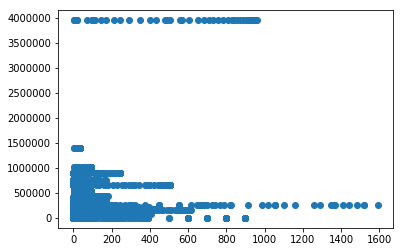

In [334]:
current_day = full_set[full_set['dateRep'] == '4/27/2020']

In [313]:
current_day.head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,built_per_sqkm,built_percent_of_land_area,tourists_per_built
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,4/27/2020,Afghanistan,AF,37172386.0,Asia,68,1531,0.183,4.119,0.6,...,25495.001,74.505,0.000,-1.668478,-1.457285,-1.496648,-1.132634,782.14706,0.12170,NaN
ALB,4/27/2020,Albania,AL,2866376.0,Europe,28,726,0.977,25.328,0.4,...,60318.988,39.681,3.266,-0.392243,0.114788,-0.521867,0.281710,467.90470,1.65397,30813461.1
DZA,4/27/2020,Algeria,DZ,42228429.0,Africa,425,3382,1.006,8.009,1.0,...,72629.001,27.371,2.824,-0.775309,-0.443925,-0.636465,-1.263752,3138.96912,0.13548,85352.4
AND,4/27/2020,Andorra,AD,77006.0,Europe,40,740,51.944,960.964,3.5,...,88061.969,11.938,0.000,1.607738,1.944976,1.238614,1.187921,8.28191,1.74399,688928369.7
AGO,4/27/2020,Angola,AO,30809762.0,Africa,2,26,0.006,0.084,0.0,...,65513.998,34.486,NaN,-1.048023,-1.052086,-1.144541,-0.999813,1347.37666,0.10746,7522.2


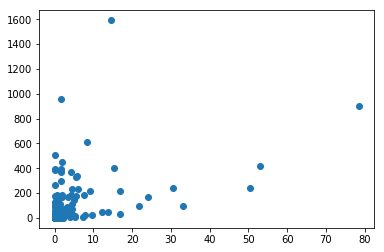

In [315]:
plt.scatter(current_day['built_percent_of_land_area'],current_day['cases_per_100k'])